In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

data_train = pd.read_csv('../data/q1/train.csv')
data_test = pd.read_csv('../data/q1/test.csv')
data_validation = pd.read_csv('../data/q1/validation.csv')

categorical_cols = data_train.select_dtypes(include='object').columns.tolist()

data_train = pd.get_dummies(data_train, columns=categorical_cols, dtype=int)
data_validation = pd.get_dummies(data_validation, columns=categorical_cols, dtype=int)
data_test = pd.get_dummies(data_test, columns=categorical_cols, dtype=int)

data_test = data_test.reindex(columns=data_train.columns, fill_value=0)
data_validation = data_validation.reindex(columns=data_train.columns, fill_value=0)


X_train = data_train.drop('result', axis=1).values
y_train = data_train['result'].values

X_validation = data_validation.drop('result', axis=1).values
y_validation = data_validation['result'].values

X_test = data_test.drop('result', axis=1).values
y_test = data_test['result'].values

In [2]:
import numpy as np
import math

class Node:
    def __init__(self, feature=None, is_leaf=False, target=None):
        self.feature = feature
        self.is_leaf = is_leaf
        self.target = target
        self.threshold = None
        self.left = None
        self.right = None


class DecisionTree:
    def __init__(self, max_depth=5, X=None, y=None, is_gini=False):
        self.max_depth = max_depth
        self.X = X
        self.y = y
        self.root = None
        self.is_gini = is_gini

    def gini_impurity(self, y):
        if len(y) == 0:
            return 0
        p = np.sum(y == 1) / len(y)
        return 1 - (p ** 2 + (1 - p) ** 2)

    def calculate_entropy(self, y):
        if len(y) == 0:
            return 0
        p = np.sum(y == 1) / len(y)
        return -(p * math.log2(p) + (1 - p) * math.log2(1 - p)) if p not in [0, 1] else 0

    def calculate_information_gain(self, X, y, feature_index):
        feature_values = X[:, feature_index]
        threshold = np.median(feature_values)

        left_mask = feature_values <= threshold
        right_mask = feature_values > threshold

        y_left, y_right = y[left_mask], y[right_mask]

        if self.is_gini:
            H = (len(y_left) / len(y)) * self.gini_impurity(y_left) + (len(y_right) / len(y)) * self.gini_impurity(y_right)
            return self.gini_impurity(y) - H
        else:
            H = (len(y_left) / len(y)) * self.calculate_entropy(y_left) + (len(y_right) / len(y)) * self.calculate_entropy(y_right)
            return self.calculate_entropy(y) - H

    def get_best_split(self, X, y):
        best_gain = 0
        best_feature = None
        n_features = X.shape[1]

        for feature_index in range(n_features):
            gain = self.calculate_information_gain(X, y, feature_index)
            if gain >= best_gain:
                best_gain = gain
                best_feature = feature_index
        return best_feature

    def build_tree(self, X, y, depth):
        if depth == self.max_depth or self.calculate_entropy(y) == 0:
            target = 1 if np.sum(y == 1) >= np.sum(y == 0) else 0
            return Node(is_leaf=True, target=target)

        best_feature = self.get_best_split(X, y)
        root = Node(feature=best_feature)
        root.target = 1 if np.sum(y == 1) >= np.sum(y == 0) else 0

        threshold = np.median(X[:, best_feature])
        root.threshold = threshold

        left_mask = X[:, best_feature] <= threshold
        right_mask = X[:, best_feature] > threshold

        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]

        if len(y_left) == 0:
            child_left = Node(is_leaf=True, target=root.target)
        else:
            child_left = self.build_tree(X_left, y_left, depth + 1)

        if len(y_right) == 0:
            child_right = Node(is_leaf=True, target=root.target)
        else:
            child_right = self.build_tree(X_right, y_right, depth + 1)

        root.left = child_left
        root.right = child_right

        return root

    def fit(self):
        self.root = self.build_tree(self.X, self.y, 0)

    def predict_one(self, x):
        current_node = self.root
        while not current_node.is_leaf:
            feature = current_node.feature
            threshold = current_node.threshold
            if x[feature] <= threshold:
                current_node = current_node.left
            else:
                current_node = current_node.right
        return current_node.target

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])

    def accuracy(self, X, y):
        preds = self.predict(X)
        return np.sum(preds == y) / len(y) * 100

    def new_pruned_node(self, node, y = None):
        node.is_leaf = True
        node.left = None
        node.right = None
        node.target = 1 if np.sum(y == 1) >= np.sum(y == 0) else 0

    def get_nodes(self, node):
        if node.is_leaf:
            return []
        nodes = [node]
        nodes += self.get_nodes(node.left)
        nodes += self.get_nodes(node.right)
        return nodes

    def post_pruning(self, X_val, y_val,X_train,Y_train , X_test,Y_test):
        validation_accuracies = []
        test_accuracies = []
        train_accuracies = []

        count_nodes = []

        while True:
            all_nodes = [
                node for node in self.get_nodes(self.root)
                if node.left is not None
                and node.right is not None
                and node.left.is_leaf
                and node.right.is_leaf
            ]

            curr_accuracy = self.accuracy(X_val, y_val)
            best_accuracy = curr_accuracy
            best_node = None

            for node in all_nodes:
                backup = (node.left, node.right, node.is_leaf, node.target)
                self.new_pruned_node(node)
                new_accuracy = self.accuracy(X_val, y_val)
                node.left, node.right, node.is_leaf, node.target = backup

                if new_accuracy >= best_accuracy:
                    best_accuracy = new_accuracy
                    best_node = node

            if best_node is None or len(validation_accuracies) >= 4000:
                break

            self.new_pruned_node(best_node)
            count_nodes.append(2 * len(self.get_nodes(self.root)) + 1)
            validation_accuracies.append(best_accuracy)
            train_accuracies.append(self.accuracy(X_train, Y_train))
            test_accuracies.append(self.accuracy(X_test, Y_test))

        return count_nodes, train_accuracies, validation_accuracies, test_accuracies

                            


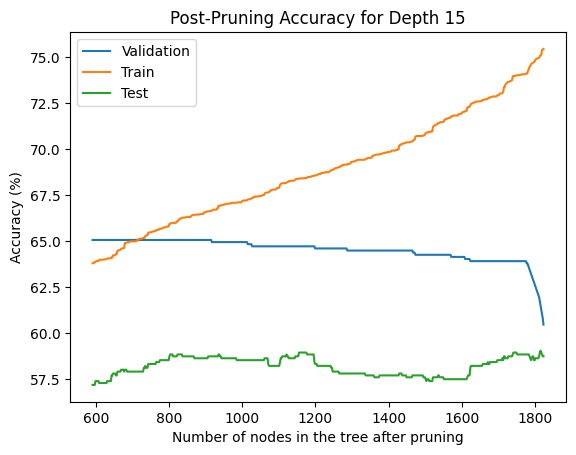

Train-accuracy for depth 15 :  63.79200204420595 %
Validation-accuracy for depth 15 :  65.05747126436782 %
Test-accuracy for depth 15 :  57.187176835573936 %

-----------------------------------


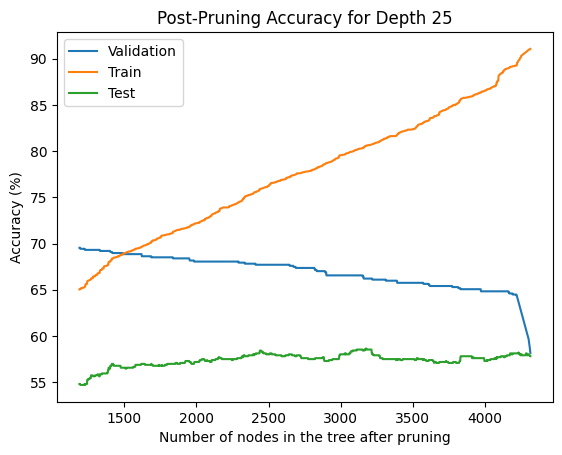

Train-accuracy for depth 25 :  65.03130190366679 %
Validation-accuracy for depth 25 :  69.54022988505747 %
Test-accuracy for depth 25 :  54.80868665977249 %

-----------------------------------


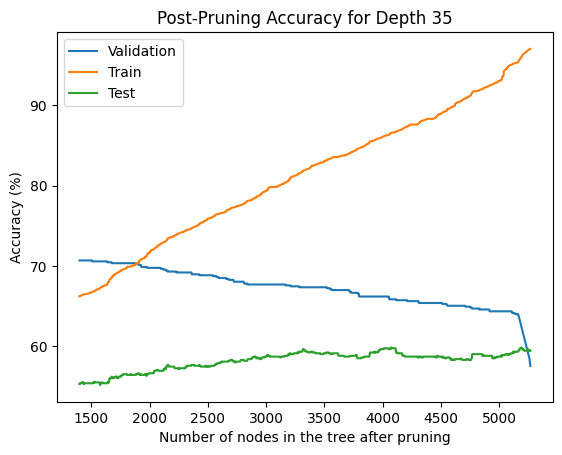

Train-accuracy for depth 35 :  66.20672032707296 %
Validation-accuracy for depth 35 :  70.6896551724138 %
Test-accuracy for depth 35 :  55.32574974146846 %

-----------------------------------


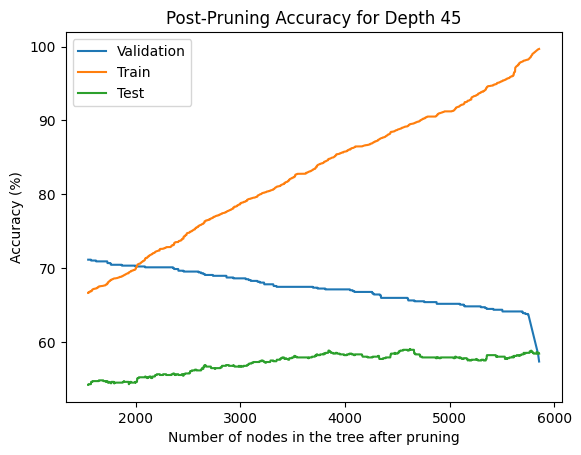

Train-accuracy for depth 45 :  66.64111409224479 %
Validation-accuracy for depth 45 :  71.14942528735632 %
Test-accuracy for depth 45 :  54.188210961737326 %

-----------------------------------


In [3]:
depth = [15, 25 , 35 , 45]
for dpt in depth:
    Dtree = DecisionTree(max_depth = dpt ,X = X_train, y = y_train, is_gini = True)
    Dtree.fit()
    
    
    count_nodes, train_accuracies, validation_accuracies, test_accuracies = Dtree.post_pruning(X_validation, y_validation, X_train, y_train, X_test, y_test)
    plt.plot(count_nodes, validation_accuracies)
    plt.plot(count_nodes, train_accuracies)
    plt.plot(count_nodes, test_accuracies)
    
    plt.xlabel("Number of nodes in the tree after pruning")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Post-Pruning Accuracy for Depth {dpt}")
    plt.legend(["Validation", "Train", "Test"])
    plt.show()

    print(f"Train-accuracy for depth {dpt} : ", Dtree.accuracy(X_train, y_train) , '%')
    print(f"Validation-accuracy for depth {dpt} : ", Dtree.accuracy(X_validation, y_validation) , '%')
    print(f"Test-accuracy for depth {dpt} : ", Dtree.accuracy(X_test, y_test) , '%')

    print()
    print('-----------------------------------')
